# Spotify Data Analysis

Music is an incredibly important aspect of my life. Very few days go by where I don't jam out to several songs. I've always been curious to examine the trends within my music data. I'm finally enabled to do so. So, here it is. 

I'll be breaking down my analysis and be showing the code that goes along with it. 

To start we need data. One can download their spotify data using this [link](https://www.spotify.com/ca-en/account/privacy/). Just login and you can request a download of your listening data.  
  
The data comes in JSON format so the first step is to transform the data into a more usable form. To do this, we'll use the Pandas library.

In [2]:
import types
import pandas as pd

df_data = pd.read_json("one_year_streaming_history0.json")
print(df_data.dtypes)
df_data.head()

endTime       object
artistName    object
trackName     object
msPlayed       int64
dtype: object


,endTime,artistName,trackName,msPlayed
0,2019-01-05 05:32,Tonight Alive,World Away,0
1,2019-01-05 05:36,Eminem,Greatest,226937
2,2019-01-05 05:40,Elephante,Sirens,249411
3,2019-01-05 05:45,Mike Williams,Bambini,2972
4,2019-01-05 05:45,Panic! At The Disco,High Hopes,190946


If you notice the endTime column is listed as an __object__. Let's convert that to a _datetime_ so that it's easier to work with.

In [2]:
df_data['endTime'] = pd.to_datetime(df_data['endTime']) 
df_data.dtypes

endTime       datetime64[ns]
artistName            object
trackName             object
msPlayed               int64
dtype: object

From there, I want to restructure the data so that that I can break each artist up into the amount of time I listened to them in a particular month.  

In [34]:
df_by_artist = df_data.groupby([df_data['endTime'].dt.month, df_data['artistName']]).sum().reset_index()
df_by_artist.rename(columns={'endTime': 'month'}, inplace=True)
df_by_artist

,month,artistName,msPlayed
0,1,12th Planet,205394
1,1,88GLAM,42992
2,1,ARTY,2786
3,1,Alec Benjamin,678654
4,1,Apashe,2225343
...,...,...,...
552,12,The Weeknd,604719
553,12,Thomas Rhett,223626
554,12,YBN Cordae,351654
555,12,YUNGBLUD,192068


Also that __endtime__ column is more of a _month_ than an __endtime__ so I changed it's name

The reason I want to structure it this way is because I tend to find new artists month to month and end up phasing out artists after a while. The plan is to look at what my top artists were for each month for the last year.

First thing I'm going to do is break my dataframe into a list of dataframes for each month that way I can easily sort the top values within each month.

In [35]:
list_dfs_month = [None] * 12

for i in range(len(list_dfs_month)):
    list_dfs_month[i] = df_by_artist[df_by_artist['month'] == i + 1].sort_values(by=['msPlayed'], ascending=False).reset_index()

print(list_dfs_month[0])
print(list_dfs_month[11])

index  month               artistName  msPlayed
0       7      1  Black Tiger Sex Machine  24633275
1       5      1            Ariana Grande  22492479
2      66      1             Virtual Riot   6290729
3      13      1                   Datsik   3839648
4      57      1     The Naked And Famous   2758170
..    ...    ...                      ...       ...
66      2      1                     ARTY      2786
67     14      1              Denis Kenzo      2101
68     61      1                   Trampa      1648
69     17      1                    Drake       997
70     60      1            Tonight Alive         0

[71 rows x 4 columns]
    index  month               artistName  msPlayed
0     533     12         Carly Rae Jepsen   8639890
1     534     12               Dan + Shay   6460271
2     529     12                     3LAU   2386749
3     537     12             Foo Fighters   1360192
4     550     12         The Chainsmokers   1313891
5     539     12                   Halsey   1

I'll also divide all the msPlayed values by 1000 to get them into seconds and replace the column name to be seconds.

In [36]:
for month_df in list_dfs_month:
    month_df['msPlayed'] = month_df['msPlayed'] / 1000
    month_df.rename(columns={'msPlayed' : 'secPlayed'}, inplace=True)

print(list_dfs_month[0])
print(list_dfs_month[11])

index  month               artistName  secPlayed
0       7      1  Black Tiger Sex Machine  24633.275
1       5      1            Ariana Grande  22492.479
2      66      1             Virtual Riot   6290.729
3      13      1                   Datsik   3839.648
4      57      1     The Naked And Famous   2758.170
..    ...    ...                      ...        ...
66      2      1                     ARTY      2.786
67     14      1              Denis Kenzo      2.101
68     61      1                   Trampa      1.648
69     17      1                    Drake      0.997
70     60      1            Tonight Alive      0.000

[71 rows x 4 columns]
    index  month               artistName  secPlayed
0     533     12         Carly Rae Jepsen   8639.890
1     534     12               Dan + Shay   6460.271
2     529     12                     3LAU   2386.749
3     537     12             Foo Fighters   1360.192
4     550     12         The Chainsmokers   1313.891
5     539     12           

I like color in my graphs so I'm going to define a color map for the number of values. We're only going to display the top N artists for each month.

In [38]:
from matplotlib import cm

N = 15

cmap = cm.get_cmap('cool', N)
colors = []
for i in range(cmap.N):
    colors.append(cmap(i))

colors[0:5]

[(0.0, 1.0, 1.0, 1.0),
 (0.07142857142857142, 0.9285714285714286, 1.0, 1.0),
 (0.14285714285714285, 0.8571428571428572, 1.0, 1.0),
 (0.21428571428571427, 0.7857142857142857, 1.0, 1.0),
 (0.2857142857142857, 0.7142857142857143, 1.0, 1.0)]

After that, I'm going to actually do the graphing. The only intersting thing here is that I format the listening time into __HH:MM:SS__ rather than just leaving it in seconds. This is because the amount of seconds I would have listened to music in a month would be basically meaningless since we typically don't process time in grand amounts of seconds.

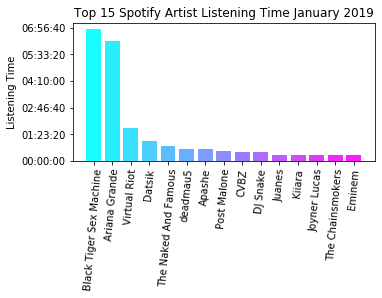

In [41]:
import matplotlib
import matplotlib.pyplot as plt
import operator
import time
import numpy as np

fig, ax = plt.subplots()
y_pos = np.arange(N)
plt.bar(y_pos, list_dfs_month[0].secPlayed[:N], align='center', alpha=0.9, color=colors)
plt.xticks(y_pos, list_dfs_month[0].artistName[:N], rotation = 85)
formatter = matplotlib.ticker.FuncFormatter(lambda sec, y: time.strftime('%H:%M:%S', time.gmtime(sec)))
ax.yaxis.set_major_formatter(formatter)
plt.gcf().subplots_adjust(bottom=0.4, left=0.2)
plt.title("Top " + '15' + " Spotify Artist Listening Time " + 'January' + " 2019")
plt.ylabel('Listening Time')

plt.show()

_Voila_ , we have our first graph. Now let's make this generalizable so that we can produce graphs for each month.

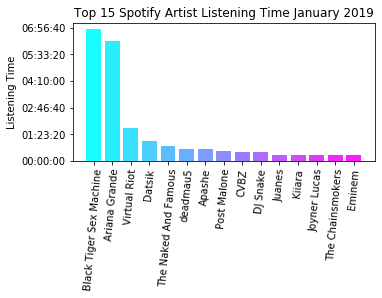

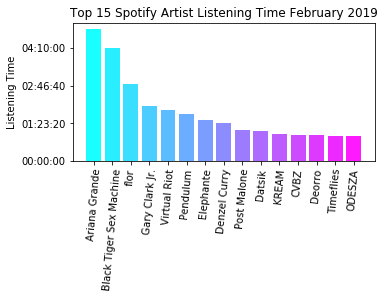

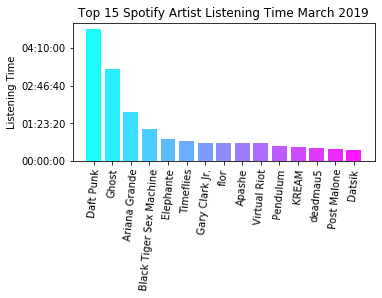

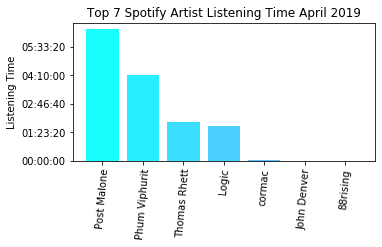

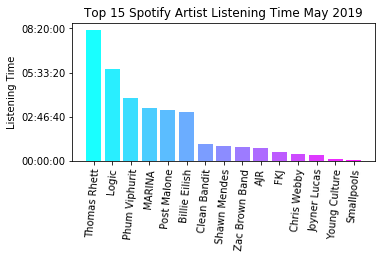

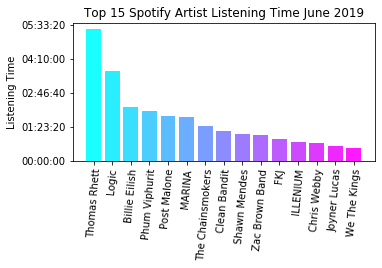

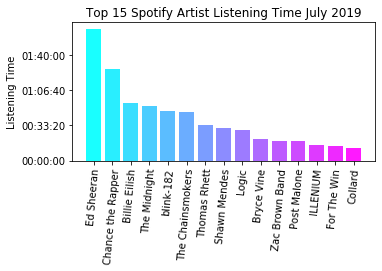

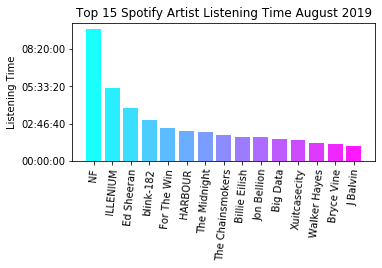

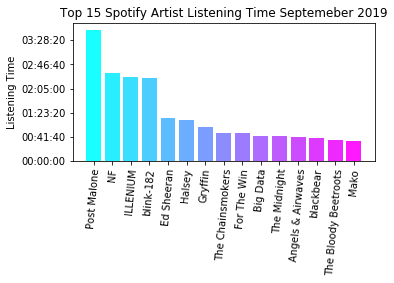

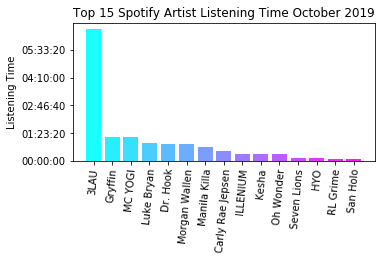

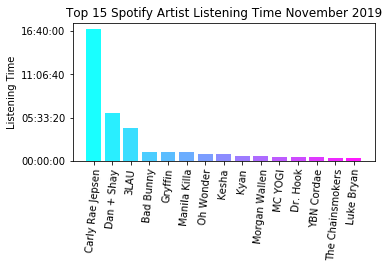

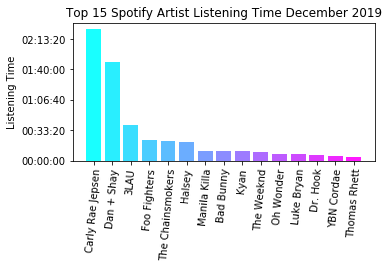

In [54]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'Septemeber', 'October', 'November', 'December']

for i in range(12):
    n = min(list_dfs_month[i].shape[0], N)

    fig, ax = plt.subplots()
    y_pos = np.arange(n)
    plt.bar(y_pos, list_dfs_month[i].secPlayed[:n], align='center', alpha=0.9, color=colors)
    plt.xticks(y_pos, list_dfs_month[i].artistName[:n], rotation = 85)
    formatter = matplotlib.ticker.FuncFormatter(lambda sec, y: time.strftime('%H:%M:%S', time.gmtime(sec)))
    ax.yaxis.set_major_formatter(formatter)
    plt.gcf().subplots_adjust(bottom=0.4, left=0.2)
    plt.title("Top " + str(n) + " Spotify Artist Listening Time " + months[i] + " 2019")
    plt.ylabel('Listening Time')

    plt.show()

The last graph I want to make is to display the top artist from each month

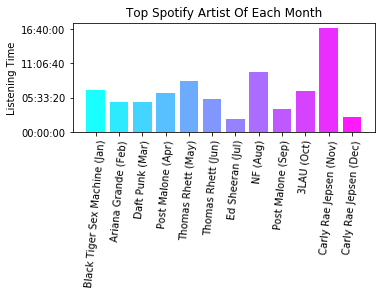

In [62]:
top_artist_by_month = []
time_played_by_month = []
for i in range(len(list_dfs_month)):
    top_artist_by_month.append(list_dfs_month[i].iloc[0].artistName + " (" + str(months[i][0:3]) + ")")
    time_played_by_month.append(list_dfs_month[i].iloc[0].secPlayed)

cmap = cm.get_cmap('cool', 12)
colors = []
for j in range(cmap.N):
    colors.append(cmap(j))

fig, ax = plt.subplots()
y_pos = np.arange(12)
plt.bar(y_pos, time_played_by_month, align='center', alpha=0.9, color=colors)
plt.xticks(y_pos, top_artist_by_month, rotation = 85)
formatter = matplotlib.ticker.FuncFormatter(lambda sec, y: time.strftime('%H:%M:%S', time.gmtime(sec)))
ax.yaxis.set_major_formatter(formatter)
plt.gcf().subplots_adjust(bottom=0.5, left=0.2)
plt.title("Top Spotify Artist Of Each Month")
plt.ylabel('Listening Time')

plt.show()

Key takeway, I __really, really, really, really, really, really__ like Carly Rae Jepsen.

_Yes that's a pun_